**Урок 6.**<br>
<b>Домашнее задание:</b> Реализовать адаптивный бустинг использующий Логистическую Регрессию и меру ошибок LogLoss. Сравнить с точностью адаптивного бустинга на деревьях решений. Для сбора предсказаний можно использовать ту же функцию predict что и для бустинга на деревьях<br>
<i>Примечания: в LogLoss необходимо передавать не предсказания полученные с помощью clf.predict(...), а вероятность, полученную с помощью clf.predict_proba(...)[:, 1]  

In [58]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

from sklearn import model_selection
import numpy as np
import warnings

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

warnings.filterwarnings('ignore')

In [59]:
def get_error(pred, y):
    return np.sum((pred != y).astype(int)) / len(y)

In [60]:
#Рекоммендуемая реализация LogLoss
def log_loss(pred, y): return -1.0 * np.sum(y * np.log(pred) + (1 - y) * np.log(1 - pred)) / len(y)

In [61]:
def adaboost(X, y, N):

    # Размер выборки
    n_objects = len(X)

    # Запишем количество классов в переменную
    n_classes = len(np.unique((y)))

    # Начальные веса деревьев
    w = np.ones(n_objects) / n_objects

    # Деревья с весами будем записывать в список
    models = []

    for n in range(N):
        # Зададим дерево и обучим его
        clf = DecisionTreeClassifier(max_depth=1)
        clf.fit(X, y, w)

        predictions = clf.predict(X)
        e = get_error(predictions, y)
        # отбросим дерево, если его ошибка больше 0.5
        # Запишем условие в общем виде (применимо к небинарным классификаторам)
        if e >= 1 - 1/n_classes: 
            break

        # Вычислим вес для дерева
        alpha = 0.5 * np.log((1 - e) / e)

        # Найдем индексы правильно классифицированных элементов
        match = predictions == y

        # Увеличим веса для неправильно классифицированных элементов
        w[~match] *= np.exp(alpha)

        # Нормализуем веса
        w /= w.sum()

        # Добавим дерево с весом в список
        models.append((alpha, clf))
    
    return models

In [62]:
def adaboost_logreg(X, y, N):

    # Размер выборки
    n_objects = len(X)

    # Запишем количество классов в переменную
    n_classes = len(np.unique((y)))

    # Начальные веса деревьев
    w = np.ones(n_objects) / n_objects

    # Деревья с весами будем записывать в список
    models = []

    for n in range(N):
        # Зададим дерево и обучим его
        lr = LogisticRegression(solver="liblinear", random_state=21)
        lr.fit(X, y, w)

        predictions = lr.predict(X)
        prediction_probs = lr.predict_proba(X)[:, 1]
        for i in range(len(prediction_probs)):
            if prediction_probs[i] == 0:
                prediction_probs[i] += 1e-14

        e = log_loss(prediction_probs, y)
        # отбросим дерево, если его ошибка больше 0.5
        # Запишем условие в общем виде (применимо к небинарным классификаторам)
        if e >= 1 - 1/n_classes: 
            break

        # Вычислим вес для дерева
        alpha = 0.5 * np.log((1 - e) / e)

        # Найдем индексы правильно классифицированных элементов
        match = predictions == y

        # Увеличим веса для неправильно классифицированных элементов
        w[~match] *= np.exp(alpha)

        # Нормализуем веса
        w /= w.sum()

        # Добавим дерево с весом в список
        models.append((alpha, lr))
    
    return models

In [63]:
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [64]:
N = 50

models = adaboost(X_train, y_train, N)
models_logreg = adaboost_logreg(X_train, y_train, N)

In [65]:
def predict(X, models):
    
    n_classes = 2
    n_objects = len(X)
    
    # вначале обозначим предсказание нулевым массивом
    y_pred = np.zeros((n_objects, n_classes))
    
    for alpha, clf in models:
        prediction = clf.predict(X)
        # Для каждого предсказания будем прибавлять alpha к
        # элементу с индексом предсказанного класса
        y_pred[range(n_objects), prediction] += alpha
    
    # выберем индексы с максимальными суммарными весами -
    # получим предсказанные алгоритмом классы
    y_pred = np.argmax(y_pred, axis=1)
    
    return y_pred

In [66]:
print(f'Точность алгоритма adaboost на обучающей выборке: {(1 - get_error(predict(X_train, models), y_train)) * 100:.3f}')
print(f'Точность алгоритма adaboost на тестовой выборке: {(1 - get_error(predict(X_test, models), y_test)) * 100:.3f}')

Точность алгоритма adaboost на обучающей выборке: 98.592
Точность алгоритма adaboost на тестовой выборке: 93.007


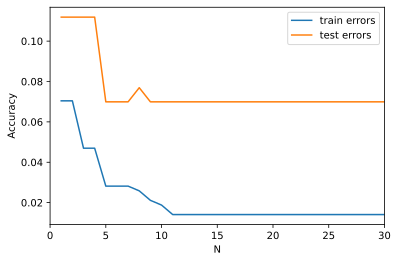

In [67]:
train_errors = []
test_errors = []

for n in range(1, 31):
    mods = adaboost(X_train, y_train, n)
    train_errors.append(get_error(predict(X_train, mods), y_train))
    test_errors.append(get_error(predict(X_test, mods), y_test))
x = list(range(1, 31))

plt.xlim(0, 30)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

In [68]:
print(f'Точность алгоритма adaboost_logreg на обучающей выборке: {(1 - get_error(predict(X_train, models_logreg), y_train)) * 100:.3f}')
print(f'Точность алгоритма adaboost_logreg на тестовой выборке: {(1 - get_error(predict(X_test, models_logreg), y_test)) * 100:.3f}')

Точность алгоритма adaboost_logreg на обучающей выборке: 93.897
Точность алгоритма adaboost_logreg на тестовой выборке: 94.406


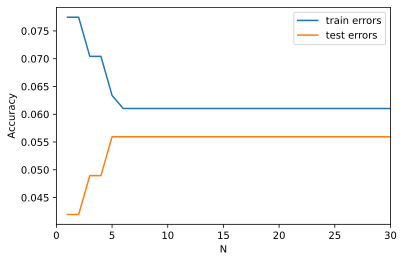

In [69]:
train_errors = []
test_errors = []

for n in range(1, 31):
    mods = adaboost_logreg(X_train, y_train, n)
    train_errors.append(get_error(predict(X_train, mods), y_train))
    test_errors.append(get_error(predict(X_test, mods), y_test))
x = list(range(1, 31))

plt.xlim(0, 30)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

**Вывод:** в моем кейсе использование бустинга на деревьях показало некоторую переобученность, а использование бустинга на алгоритмах логистической регрессии привело к более высокому значению на тестовой выборке при отсутствии переобученности.

<b>Домашнее задание(необязательное, повышенной сложности):</b> Реализовать специальную функцию predict для бустинга на логистической регрессии выводящую предсказания по формуле: $ Predictions=sign(Score_{bust}) $,
где sign равен единице для положительных и нулю для отрицательных значений, а $ Score_{bust}= \sum \alpha_iScore_i$. Баллы выдаваемые каждой моделью $Score_i$ можно найти при помощи вызова метода decision_function на моделе